<a href="https://colab.research.google.com/github/Kuehl-California-notebooks/Water-classification-Drought-or-No-Drought-expanded/blob/main/Water_classification_Drought_or_No_Drought_expanded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Perform exploratory data analysis

In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).

In [ ]:
raw_water_data_pt1 = pd.read_csv('https://raw.githubusercontent.com/ekirchman/RIPS-notebooks/master/twitsamp11.15.csv')
print(raw_water_data_pt1.shape)
raw_water_data_pt2 = pd.read_csv('https://raw.githubusercontent.com/ekirchman/RIPS-notebooks/master/droughttraining2%201.19.23.csv')
print(raw_water_data_pt1.shape)
raw_water_data = raw_water_data_pt1[["text", "lang", "Drought"]].append(raw_water_data_pt2[["text", "Drought"]])
print(raw_water_data.shape)
raw_water_data.head()

(1000, 107)
(1000, 107)
(2000, 3)


,text,lang,Drought
0,¡Californianos continúan cumpliendo con el man...,es,0.0
1,Little League Registration Info. https://t.co/...,en,0.0
2,Make your yard beautiful with permeable surfac...,en,1.0
3,DWA customers saved 8% in September. Our goal ...,en,1.0
4,@CCWD's Los Vaqueros Reservoir was looking lov...,en,1.0


## Text cleaning

In [ ]:
import string
import regex as re
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')


def text_cleaner(df):
  filter_char = lambda c: ord(c) < 256
  df["orig_text"] = df["text"]
  df["text"] = df["text"].str.lower()
  #remove URLs
  df["text"] = df["text"].str.replace("http\\S*", " ", regex=True)
  # Remove hashtags
  # NOTE: Removing hashtags decreased performance
  # df["text"] = df["text"].str.replace("#\S*", " ", regex=True)

  # Remove puncuations and emojis
  df["text"] = df["text"].str.translate(str.maketrans('', '', string.punctuation)).apply(lambda s: ''.join(filter(filter_char, s)))
  #Remove stop words
  # NOTE: Removing stop words decreased performance
  # df["text"] = df["text"].apply(lambda x: ' '.join([i for i in x.split() if i not in stopword_list]))

text_cleaner(raw_water_data)
# print(raw_water_data['text'])
# print(train_df['clean_text'])
# for i in train_df['clean_text']:
  # print(i)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Columns
# list(raw_water_data.columns)

In [ ]:
# Check if there is any duplicate tweets
total_duplicate_tweets = sum(raw_water_data["text"].duplicated())
print(f"There are {total_duplicate_tweets} duplicate titles.")

There are 36 duplicate titles.


In [ ]:
print(f"There are {raw_water_data.shape[0]} rows in the full dataset")
# Drop all tweets not in english
water_data = raw_water_data#[(raw_water_data["lang"] == 'en')]
# print(f"There are {len(water_data)} rows in the english dataset.")
orig_water_data = raw_water_data.copy()

#drop nan values in drought
print(f"number of nan vals in Drought: {water_data.Drought.isnull().sum()}")
water_data = water_data.dropna(subset=['Drought'])
print(f"There are {len(water_data)} rows in the dataset.")

There are 2000 rows in the full dataset
number of nan vals in Drought: 1
There are 1999 rows in the dataset.


In [ ]:
water_data.Drought.value_counts()
# There is 451 Drought related tweets; the largest of the two groups

0.0    1548
1.0     451
Name: Drought, dtype: int64

In [ ]:
#Will be used for later
clean_water_data = water_data.copy()

# get an equal amount from each set
drought_df = water_data[water_data['Drought'] == 1].copy()
no_drought_df = water_data[water_data['Drought'] == 0][:451].copy()
water_data = pd.concat([drought_df, no_drought_df])
water_data['Drought'].value_counts()

1.0    451
0.0    451
Name: Drought, dtype: int64

In [ ]:
# Reformat dataframe into something we can use
label_list = ['Regulations', 'Behavioral', 'Incentives', 'Information', 'Motivation', 'Skills', 'Drought']

#replace 0's with 'Not_drought'
water_data['Drought'] = water_data['Drought'].mask(water_data['Drought']==0, "['NotDrought']")
water_data['Drought'] = water_data['Drought'].mask(water_data['Drought']==1, "['Drought']")

water_data['Drought'].head(10)

2     ['Drought']
3     ['Drought']
4     ['Drought']
5     ['Drought']
6     ['Drought']
7     ['Drought']
8     ['Drought']
9     ['Drought']
10    ['Drought']
11    ['Drought']
Name: Drought, dtype: object

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [ ]:
water_data["Drought"] = water_data["Drought"].apply(
    lambda x: literal_eval(x)
)
water_data["Drought"].values[:5]

array([list(['Drought']), list(['Drought']), list(['Drought']),
       list(['Drought']), list(['Drought'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [ ]:

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    water_data,
    # test_size=test_split,
    # test_size=0.2,
    stratify=water_data["Drought"].values,
    random_state=5
)

# Splitting the test set further into validation
# and new test sets.
# val_df = test_df.sample(frac=0.5)
# test_df.drop(val_df.index, inplace=True)

train_df, val_df = train_test_split(train_df,
                                     test_size=0.2,
                                     random_state=5
)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 540
Number of rows in validation set: 136
Number of rows in test set: 226


## Multi-class binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [ ]:
labels = tf.ragged.constant(train_df["Drought"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(labels)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'Drought', 'NotDrought']


Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [ ]:
sample_label = train_df["Drought"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Drought']
Label-binarized representation: [[0. 1. 0.]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [ ]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    540.000000
mean      24.120370
std       11.544636
min        2.000000
25%       16.000000
50%       21.000000
75%       32.250000
max       52.000000
Name: text, dtype: float64

Notice that 50% of the abstracts have a length of 20 . So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [ ]:
max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["Drought"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


Now we can prepare the `tf.data.Dataset` objects.

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'crane update 2nd crane failed lgr crane enroute frances remains closed frm washington evelyn'
Label(s): ['NotDrought']
 
Abstract: b'filmmakers submit your short films in any genre on the topic of water for a chance to win 1500 and other  '
Label(s): ['Drought']
 
Abstract: b'are you and your family ready if an emergency occurs be prepared with ready eddie learn how to stage your home  '
Label(s): ['NotDrought']
 
Abstract: b'we have info on how our lawn to garden rebate compares to the states apply to both to double your rebate \n '
Label(s): ['Drought']
 
Abstract: b'save the date for this free workshop from the wcgarden attendees will learn which questions to ask how to plan and ways to save money when hiring a landscape professional more info at   stayathome watersmart  '
Label(s): ['Drought']
 


## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the tweet body text.

In [ ]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

3351


In [ ]:
vocabulary

{'connection',
 'weeds',
 'leaving',
 'cleanwaterwed',
 'penny',
 'laundry',
 'sector',
 'compared',
 'ohio',
 'systems',
 'brews',
 'calling',
 'those',
 'throw',
 'coffee',
 'leaks',
 '1977',
 'flint',
 'salt',
 'manufacturing',
 'walk',
 'shuttle',
 'did',
 'historic',
 'nwssandiego',
 'test',
 'sdregionaledc',
 'airresources',
 'costs',
 'drive',
 'storm',
 'equipment',
 'introducing',
 '14',
 'education',
 'operating',
 'team',
 'años',
 'account',
 '29',
 'drop',
 'lavwatertalks',
 'of',
 'wcgarden',
 'package',
 'viven',
 'discuss',
 'enroll',
 '5106684200',
 'brushing',
 'rei',
 '0616',
 'blog',
 'inches',
 'carefully',
 'turning',
 'past',
 '7pm',
 'fleminghill',
 '21',
 'socaltapwater',
 'quasquicentennial',
 'biotech',
 'application',
 'volunteer',
 'empresas',
 'scwd',
 'distributing',
 'attending',
 'win',
 'rebates',
 'customer',
 'information',
 'sfsu',
 'impact',
 'today',
 'info',
 'multiple',
 'trash',
 'months',
 '2000',
 'lewis',
 'fed',
 'farmer',
 'malone',
 'affe

We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size,
    # max_tokens=20000,
     ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [ ]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            # layers.Dense(512, activation="relu"), #relu
            # Try to add in RNN via LSTM
            # layers.Embedding(input_dim=1000, output_dim=64),
            # layers.LSTM(128),
            layers.Dense(256, activation="relu"),
            # layers.Dense(512, activation="relu"),
            # layers.Dropout(0.2),
            # layers.Dense(256, activation="relu"),
            # layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
            layers.Dense(lookup.vocabulary_size(), activation="softmax"), # sigmoid
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in
[Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

Epoch 1/8
5/5 [==============================] - 0s 39ms/step - loss: 0.9977 - categorical_accuracy: 0.5389 - val_loss: 0.6080 - val_categorical_accuracy: 0.7059
Epoch 2/8
5/5 [==============================] - 0s 20ms/step - loss: 0.2592 - categorical_accuracy: 0.9333 - val_loss: 0.4629 - val_categorical_accuracy: 0.7868
Epoch 3/8
5/5 [==============================] - 0s 17ms/step - loss: 0.1071 - categorical_accuracy: 0.9870 - val_loss: 0.5372 - val_categorical_accuracy: 0.7574
Epoch 4/8
5/5 [==============================] - 0s 16ms/step - loss: 0.0715 - categorical_accuracy: 0.9926 - val_loss: 0.4385 - val_categorical_accuracy: 0.8015
Epoch 5/8
5/5 [==============================] - 0s 14ms/step - loss: 0.0425 - categorical_accuracy: 0.9963 - val_loss: 0.4543 - val_categorical_accuracy: 0.8162
Epoch 6/8
5/5 [==============================] - 0s 16ms/step - loss: 0.0331 - categorical_accuracy: 0.9963 - val_loss: 0.4896 - val_categorical_accuracy: 0.7941
Epoch 7/8
5/5 [=============

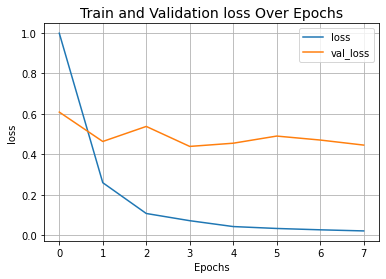

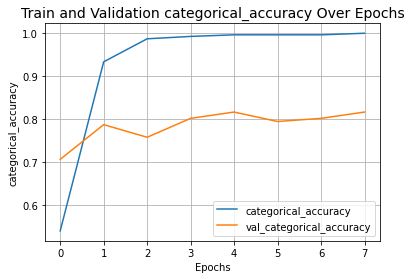

In [ ]:
epochs = 8

# max_features = 20000
# embedding_dim = 128

# # A integer input for vocab indices.
# inputs = tf.keras.Input(shape=(None,), dtype="int64")

# # Next, we add a layer to map those vocab indices into a space of dimensionality
# # 'embedding_dim'.
# x = layers.Embedding(max_features, embedding_dim)(inputs)
# x = layers.Dropout(0.5)(x)

# # Conv1D + global max pooling
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.GlobalMaxPooling1D()(x)

# # We add a vanilla hidden layer:
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.3)(x)

# # We project onto a single unit output layer, and squash it with a sigmoid:
# predictions = layers.Dense(3, activation="sigmoid", name="predictions")(x)

# model = tf.keras.Model(inputs, predictions)

# # Compile the model with binary crossentropy loss and an adam optimizer.
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# history = model.fit(
#     train_dataset, validation_data=validation_dataset, epochs=epochs
# )


shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"] #binary_crossentropy
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

# _, categorical_acc = model.evaluate(test_dataset)
# print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

2/2 [==============================] - 0s 7ms/step - loss: 0.5217 - categorical_accuracy: 0.7876
Categorical accuracy on the test set: 78.76%.


The trained model gives us an evaluation accuracy of what is shown above.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(10), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

1/1 [==============================] - 0s 186ms/step
Text: b'there are many ways that we can save water during the drought from installing a smart sprinkler controller to replacing your lawn this is how we save water for watersaving tips and rebates visit    '
Label(s): ['Drought']
Predicted Label(s): (Drought, NotDrought, [UNK])
 
Text: b'singleuse wipes that say flushable may go down the toilet but they end up clogging sewer pipes and treatment equipment nowipesinthepipes whattoflush wipesclogpipes notsoflushable centralsan ocsewers casacleanwater ladwp goletasanitation  '
Label(s): ['NotDrought']
Predicted Label(s): (NotDrought, Drought, [UNK])
 
Text: b'its smartirrigationmonth july is a peak month for outdoor water use and a great time to improve irrigation efficiency for tips to help you save during smart irrigation month click here    '
Label(s): ['Drought']
Predicted Label(s): (Drought, NotDrought, [UNK])
 
Text: b'sanelijolife  vwd had a water main break on san elijo road sout

Output inaccurately predicted tweets to CSV

In [ ]:
#Set batch size to the size of the number of tweets in file
batch_size = clean_water_data.shape[0]

#replace 0's with 'Not_drought'
clean_water_data['Drought'] = clean_water_data['Drought'].mask(clean_water_data['Drought']==0, "['NotDrought']")
clean_water_data['Drought'] = clean_water_data['Drought'].mask(clean_water_data['Drought']==1, "['Drought']")

clean_water_data["Drought"] = clean_water_data["Drought"].apply(
    lambda x: literal_eval(x)
)

# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a dataset
inference_dataset = make_dataset(clean_water_data, is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Create empty CSV to save results in
csv_df = pd.DataFrame(columns=['Text', 'Text_Orig' 'Label', 'Predicted_Label',
                               'Prediction_Probability'])

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    # print(f"Text: {text}")
    # print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    # print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    # print(" ")

    pred_labels = sorted(predicted_proba, reverse = True)[:3]
    temp_row = {"Text": text.numpy().decode("utf-8"),
                "Label":invert_multi_hot(label[0])[0],
                "Predicted_Label": f"{top_3_labels[0]}",
                "Prediction_Probability": pred_labels[0]}
    # print(temp_row)
    csv_df = csv_df.append(temp_row, ignore_index = True)
# print(csv_df)
path = "/content/Water_classification_Drought_output.csv"
csv_df.to_csv(path)
print(f"saved to {path}")

63/63 [==============================] - 1s 10ms/step
saved to /content/Water_classification_Drought_output.csv


In [ ]:
# New cell for predicting Drought. 
# Does not use make_dataset func
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])
dataset = tf.data.Dataset.from_tensor_slices(
    (raw_water_data["text"].values)
)
i_dataset = dataset.batch(2000)
text_batch = next(iter(i_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    # label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    # print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

63/63 [==============================] - 0s 3ms/step
Text: b'\xc2\xa1Californianos contin\xc3\xbaan cumpliendo con el mandato de conservaci\xc3\xb3n de agua de @JerryBrownGov por el s\xc3\xa9ptimo mes!  https://t.co/ZiMvn79UyO'
Predicted Label(s): (NotDrought)
 
Text: b'Little League Registration Info. https://t.co/W1JZWqYUFg'
Predicted Label(s): (NotDrought)
 
Text: b'Make your yard beautiful with permeable surfaces in your landscape that helps rainwater &amp; irrigation pass through and replenish groundwater. https://t.co/8fl789UckU'
Predicted Label(s): (Drought)
 
Text: b"DWA customers saved 8% in September. Our goal for long-term is 10-13%. If you still have work to do to #keepsaving, now's the time! https://t.co/bS4kqvHqGq"
Predicted Label(s): (Drought)
 
Text: b"@CCWD's Los Vaqueros Reservoir was looking lovely yesterday at 90% of capacity. Pumping's resumed and it is filling again. https://t.co/H4eOxdbfeU"
Predicted Label(s): (NotDrought)
 
Text: b'#TBT When we learned why local

KeyboardInterrupt: ignored

### Testing out Distilbert

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.5 MB/s 
     |████████████████████████████████| 7.6 MB 55.8 MB/s 
     |████████████████████████████████| 182 kB 66.2 MB/s 


In [ ]:
#importing distil BERT model and its tokenizer for Tesnforflow use
from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
BERT_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
BERT_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
#give these easy identifiers
tweet_text = clean_water_data.text
drought_labels = clean_water_data.Drought

#split into train, validation, test
tweet_train, tweet_test, drought_train, drought_test = train_test_split(tweet_text, drought_labels, test_size=0.2, random_state=10)
tweet_train, tweet_validate, drought_train, drought_validate = train_test_split(tweet_train, drought_train, test_size=0.25, random_state=10)

In [ ]:
#tokenize all of the training parameters
x_train = BERT_tokenizer(
    text=tweet_train.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

In [ ]:
#Set up the model

max_length = 512 #The max length of input
max_length = 126

input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

embeddings = BERT_model(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = layers.Dense(32, activation='relu')(out)

y=layers.Dense(6, activation='sigmoid')(out)

final_model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
final_model.layers[2].trainable=True

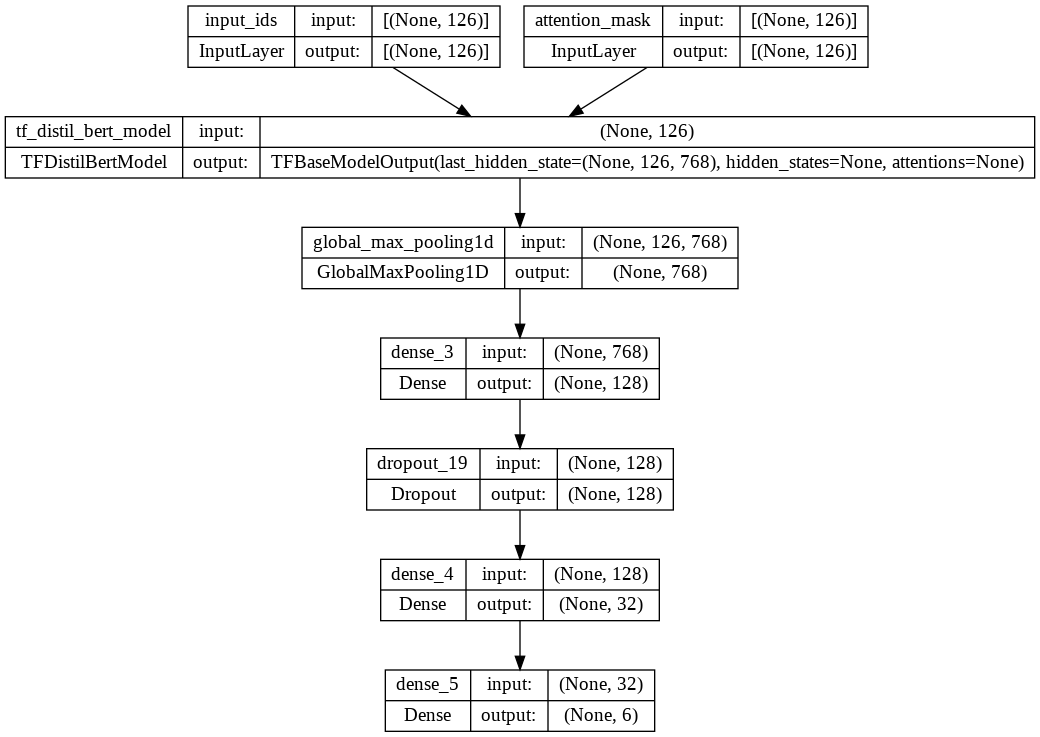

In [ ]:
#Plot the model
tf.keras.utils.plot_model(final_model, show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:
optimizer = Adam(learning_rate=5e-05,
                 epsilon=1e-08,
                 decay=0.01,
                 clipnorm=1.0)

loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

final_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=metric
)

In [ ]:
#tokenize the validation set
x_validate = BERT_tokenizer(
    text=tweet_validate.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

#tokenize the test set
x_test = BERT_tokenizer(
    text=tweet_test.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# #obtain the saved model checkpoint to prevent re-training
# checkpoint_path = "training_1.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# #save the model weights
# callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
#                                               save_weights_only = True,
#                                               verbose=1)

In [ ]:
#load the weights into the model
# final_model.load_weights("/content/drive/MyDrive/training_1.ckpt")

In [ ]:
#fit the model with the train set
#Only needed to be ran once for demo and testing saving and loading model weights

# train_history = final_model.fit(
#    x = {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
#    y = drought_train,
#    validation_data = (
#        {'input_ids':x_validate['input_ids'], 'attention_mask':x_validate['attention_mask']},
#        drought_validate
#    ),
#    epochs=1,
#    batch_size=5,
#    callbacks=[callback]
# )

KeyboardInterrupt: ignored

In [ ]:
# clean_water_data['Regulations'].value_counts()